In [177]:
import matplotlib.pyplot as plt 
from PIL import Image, ImageOps, ImageShow
import numpy as np

In [178]:
def read_image_as_numpy_array(image_path) :
    with Image.open(image_path) as image:
        np_image = np.array(image)
        return np_image

In [179]:
import pathlib
current_dir = pathlib.Path.cwd()
image_file = pathlib.Path.joinpath(current_dir,"Lenna.png")

In [180]:
def show_image(image):
    #greys = ["Greys_r", "Greys_g", "Greys_b"]
    plt.figure(figsize=(15,10))
    for i in range(3):
        plt.subplot(2,3, i +1)
        plt.title(f"Channel: {i}")
        channel = image[:,:,i]
        plt.imshow(channel, "Greys_r")

def show_image_histogram(image):
    plt.figure(figsize=(15,5))

    for i in range(3):
        channel = image[:,:,i]
        plt.subplot(1,3,i+1)
        show_histogram(channel, plotColor= 'black',titlePlot=f"Hist Channel {i+1}")

In [181]:
lenna_image = read_image_as_numpy_array(image_file)

Display RGB channels of image

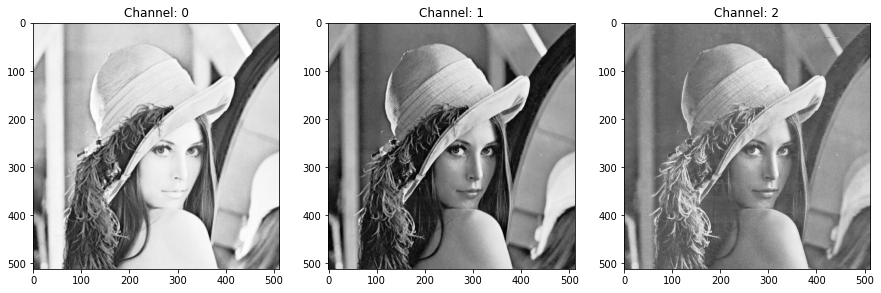

In [182]:
show_image(lenna_image)

In [183]:
def show_histogram(input_array, plotColor = 'green' ,num_bins = 255, titlePlot = 'ColorMap', yLabel = 'Freq', xLabel='Intensity') :
   
     input_array = input_array.reshape( (-1,1))
     n, bins, patches = plt.hist(input_array, num_bins, cumulative=False,
                              density = False, 
                              color = plotColor,
                              alpha = 0.7)
     plt.xlabel(xLabel)
     plt.ylabel(yLabel)

     plt.title(titlePlot, fontweight ="bold")

Histogram for rgb channels freq distribution

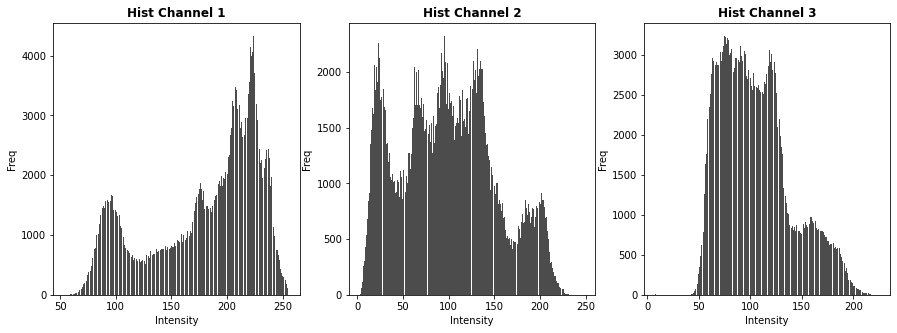

In [184]:
show_image_histogram(lenna_image)

Inverted Image Plot

In [185]:
def invert_image(image_2d_array):
    inverted_image = 255 - image_2d_array
    return inverted_image

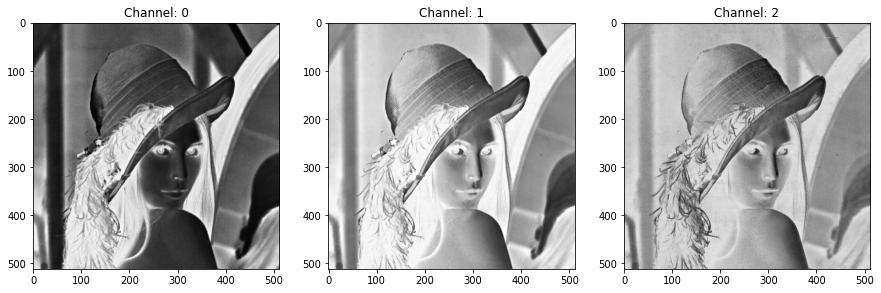

In [186]:
lenna_image_inverted = invert_image(lenna_image)
show_image(lenna_image_inverted)

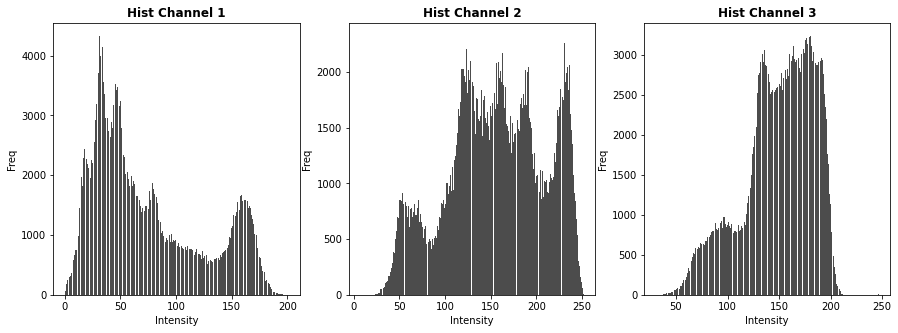

In [187]:
show_image_histogram(lenna_image_inverted)

(512, 512)
(512, 512)
(512, 512)


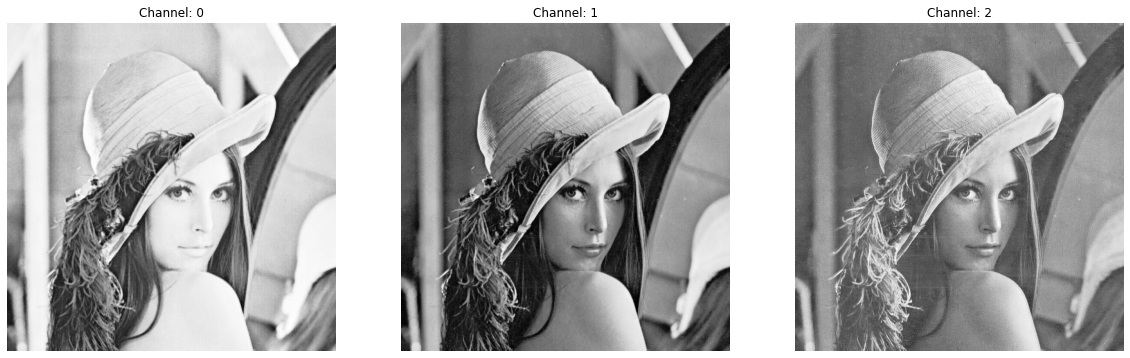

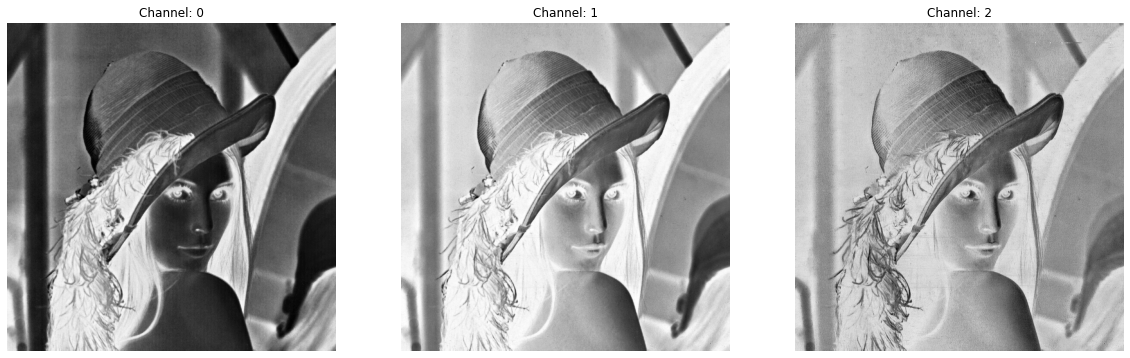

In [188]:
from typing import Callable
from functools import partial
from numpy import ndarray

def execute_custom_operation( input_lambda, subplot_row=1, subplot_column =3):
    plt.figure( figsize=(20,10) )

    for i in range(3):
        plt.subplot( subplot_row, subplot_column, i+1)
        input_lambda(i)

def figure_channel_wrapper(index, lambda_to_execute):
    plt.title(f"Channel: {index}")
    lambda_to_execute(index)
    plt.axis("off")

def plot_channel(channels: ndarray, index: int):

    channel_copy = np.array(channels, copy=True)

    figure_channel_wrapper( index, lambda x:
                plt.imshow(channel_copy[ :, :, x],cmap='Greys_r')
            )

def plot_inverted_channel(channels: ndarray, index: int) -> None:
    channel_copy = np.array(channels, copy=True)

    def invert_and_show(index):
        inverted_data = invert_image(channel_copy[:,:,index])
        print(inverted_data.shape)
        plt.imshow(inverted_data, cmap='Greys_r')

    figure_channel_wrapper( index, (lambda x: 
                invert_and_show(x)
            )
        )

channel_plot = partial(plot_channel, channels = lenna_image)
channel_inverted_plot = partial(plot_inverted_channel, channels = lenna_image)

execute_custom_operation( lambda x: channel_plot(index=x), subplot_row=1 )
execute_custom_operation( lambda x: channel_inverted_plot(index=x), subplot_row=1 )

Spatial Filter(Linear + Non Linear)

In [189]:
# assume 3x3 filter
def manipulate(image_array, x_index, y_index, execute):
    a = image_array
    i,j = x_index, y_index

    input_array = [ a[i-1, j-1] , a[i, j-1] , a[i+1,j-1]
             , a[i-1, j] , a[i, j] , a[i+1,j]
            , a[i-1, j+1] , a[i, j+1] , a[i+1,j+1]
            ]

    return execute(input_array)

    # return int(np.sum(input_array)/len(input_array))

    # result: np.int16 = (a[i-1, j-1] + a[i, j-1] + a[i+1,j-1]
    #          + a[i-1, j] + a[i, j] + a[i+1,j]
    #         + a[i-1, j+1] + a[i, j+1] + a[i+1,j+1]
    #         )
    # return int(result/9)

def max_pixel(image_array, x_index, y_index):
    operation = lambda arr :  np.max(arr)#np.amin(arr)
    return manipulate(image_array, x_index, y_index,operation)

def min_pixel(image_array, x_index, y_index):
    operation = lambda arr :  np.min(arr)#np.amin(arr)
    return manipulate(image_array, x_index, y_index,operation)

def median_pixel(image_array, x_index, y_index):
    operation = lambda arr :  np.median(arr)#np.amin(arr)
    return manipulate(image_array, x_index, y_index,operation)

def avg_pixel(image_array, x_index, y_index):
    averager = lambda arr : int(sum(arr)/len(arr))
    return manipulate(image_array, x_index, y_index,averager)

def filter_out(image_array, filter_operation):
    width,height = image_array.shape
    
    for i in range(1,width-1):
        for j in range(1,height-1):
            image_array[i,j] = filter_operation(image_array, i, j)

In [190]:
def plot_with_filter(channels: ndarray, index: int,filter_opeartor, should_invert_image:bool = False) -> None:
    channel_copy = np.array(channels, copy=True)
    def invert_filter_and_show(index):
        if should_invert_image:
            inverted_data = invert_image(channel_copy[:,:,index])
        else:
            inverted_data = channel_copy[:,:,index]
        filter_out(inverted_data, filter_opeartor)
        plt.imshow(inverted_data, cmap='Greys_r')

    figure_channel_wrapper( index, (lambda x: 
                invert_filter_and_show(x)
            )
        )


Max Filter on Inverted

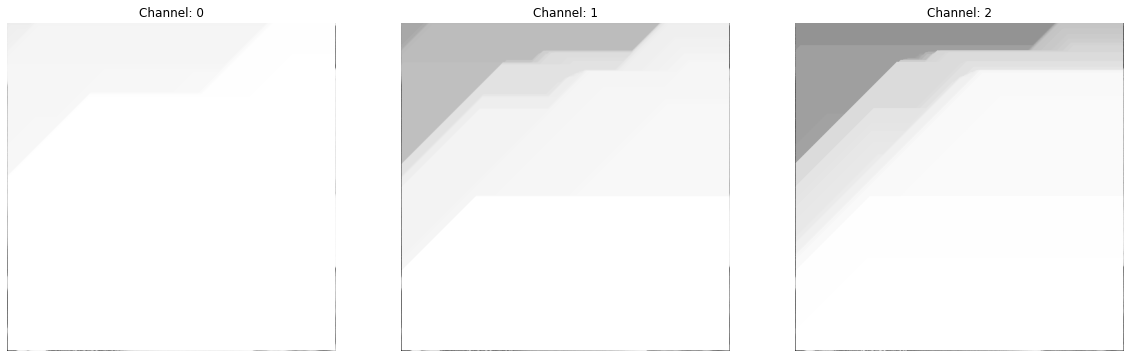

In [191]:
inverted_filter = partial(plot_with_filter, channels = lenna_image,should_invert_image=False)

execute_custom_operation( lambda x: inverted_filter(index=x,filter_opeartor=max_pixel), subplot_row=1 )



Min Filter on Inverted



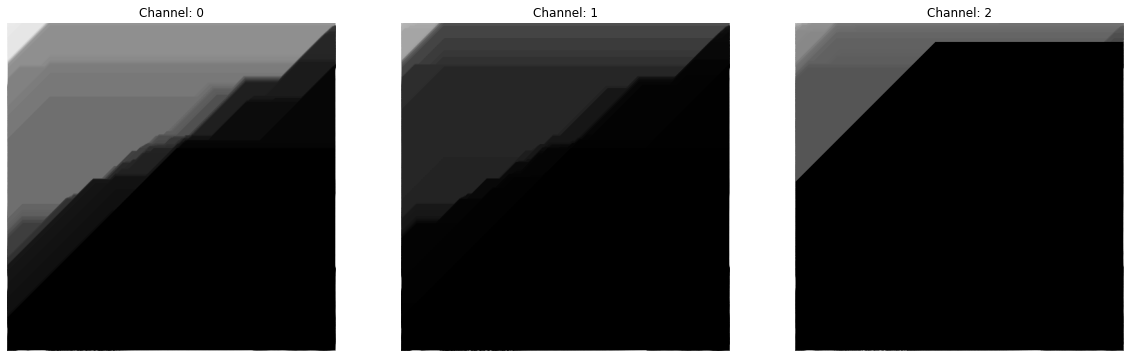

In [192]:
execute_custom_operation( lambda x: inverted_filter(index=x,filter_opeartor=min_pixel), subplot_row=1 )


Median Filter on Inverted Image

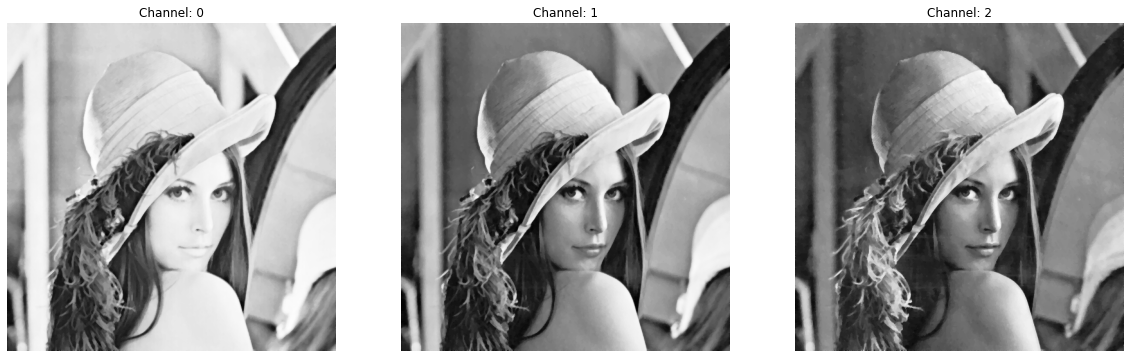

In [193]:
execute_custom_operation( lambda x: inverted_filter(index=x,filter_opeartor=median_pixel), subplot_row=1 )


Avg Filter on Inverted Image

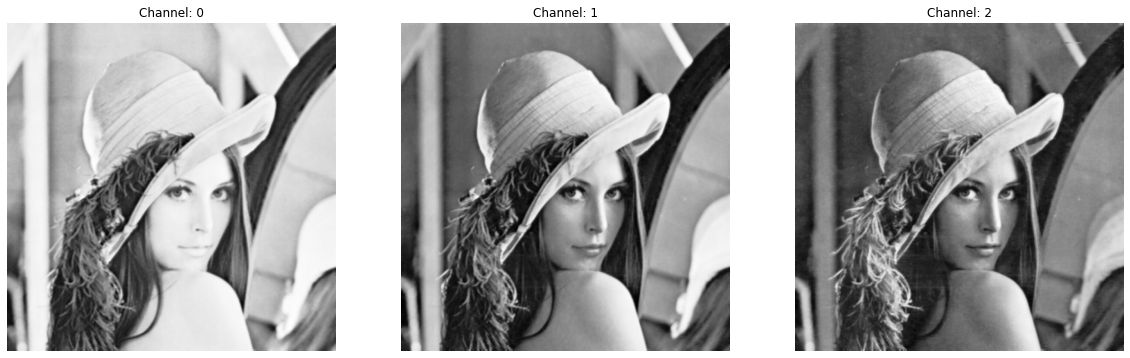

In [194]:
execute_custom_operation( lambda x: inverted_filter(index=x,filter_opeartor=avg_pixel), subplot_row=1 )
